<a href="https://colab.research.google.com/github/chanel00/Spotify-Project-Fall-2023/blob/main/Final_Spotify_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spotify Song Popularity Score Prediction:**

By: Max Schultz, Tatum Hennessey, Chanel Thorpe, Anushka Bhat

In [ ]:
#importing the necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import *

Let's read our data and look at the first five rows...

In [ ]:
df = pd.read_csv('SpotifyFeatures.csv')
df.head()

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737             0.000  F#    0.1510    -5.559  Minor   
2       170267   0.131             0.000   C    0.1030   -13.879  Minor   
3       152427   0.326             0.000  C#    0.0985   -12.178  Major   
4        82625   0.225             0.123   F    0.2020   -21.150  Major   

   speechiness    tempo time_signature  valence  
0       0.0525  166.969            4/4    0.814  
1       0.0868  174.003            4/4    0.816  
2       0.0362   99.488            5/4    0.368  
3       0.0395  171.758            4/4    0.227  
4       0.0456  140.576            4/4    0.390

# **Cleaning the data:**

In [ ]:
df.isnull().sum() # using this to see if there are any null values in our df and if so, how many in each column?
# this also give us the type of data we are working with which is very useful

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

We realized there were a bunch of duplicates in our dataset so we dropped those extra rows using df.drop_duplicates(), and filtered through songs that have the same track_name and artist_name.

In [ ]:
df = df.drop_duplicates(subset=['track_name', 'artist_name'])
df.shape

(176514, 18)

After this cleaning, our data has been significantly reduced; however, this is beneficial overall — and this prepares are data for Regression and Machine Learning methods.

# **Statistical Tests:**

The first statistical test we will use is a correlation analysis of the popularity column and a song's loudness. As times shift forward, one of the most common things you will hear from older generations is that music nowadays is obnoxiously loud. To see if this holds, lets calculate R^2 (the coefficient of determination) between popularity and loudness to see what percentage of a song's popularity is explained by its loudness.

In [ ]:
from scipy.stats import pearsonr

correlation_coefficient, p_value = pearsonr(df['popularity'], df['loudness'])

print(f'R: {round(correlation_coefficient * 100, 2)} %,', 'R^2:', round((correlation_coefficient **2)*100, 2),'%')
print(f'P-value: {p_value}')

R: 32.19 %, R^2: 10.36 %
P-value: 0.0


**As you can see, the model predicts that there is a 32.19% correlation between loudness and popularity. Further interpretation tells us that if we square that value, it will give us an R^2 of 10.36% — meaning that roughly 10.36% of a songs popularity is explained by its loudness.**



The last statistical method we will use is boxplot construction and outlier calculation... to do this we will use df.describe() to get our basic summary statistics

In [ ]:
df.describe()

popularity   acousticness   danceability   duration_ms  \
count  176514.000000  176514.000000  176514.000000  1.765140e+05   
mean       36.257634       0.403876       0.541111  2.361540e+05   
std        17.392089       0.366286       0.190441  1.305749e+05   
min         0.000000       0.000000       0.056900  1.538700e+04   
25%        25.000000       0.045500       0.415000  1.782800e+05   
50%        37.000000       0.288000       0.558000  2.194750e+05   
75%        49.000000       0.791000       0.683000  2.685730e+05   
max       100.000000       0.996000       0.989000  5.552917e+06   

              energy  instrumentalness       liveness       loudness  \
count  176514.000000     176514.000000  176514.000000  176514.000000   
mean        0.557203          0.172211       0.224628     -10.137290   
std         0.275855          0.323038       0.211150       6.398382   
min         0.000020          0.000000       0.009670     -52.457000   
25%         0.344000          0.000000       0.097500     -12.850000   
50%         0.592000          0.000071       0.130000      -8.189000   
75%         0.789000          0.091400       0.277000      -5.629000   
max         0.999000          0.999000       1.000000       3.744000   

         speechiness          tempo        valence  
count  176514.000000  176514.000000  176514.000000  
mean        0.127471     117.214397       0.451642  
std         0.204460      31.323689       0.267853  
min         0.022200      30.379000       0.000000  
25%         0.036800      92.007000       0.222000  
50%         0.049400     115.009000       0.440000  
75%         0.102000     138.825000       0.667000  
max         0.967000     242.903000       1.000000

# **Visualization #1**

Boxplot Construction that visualizes the df.describe() function for the popularity variable:

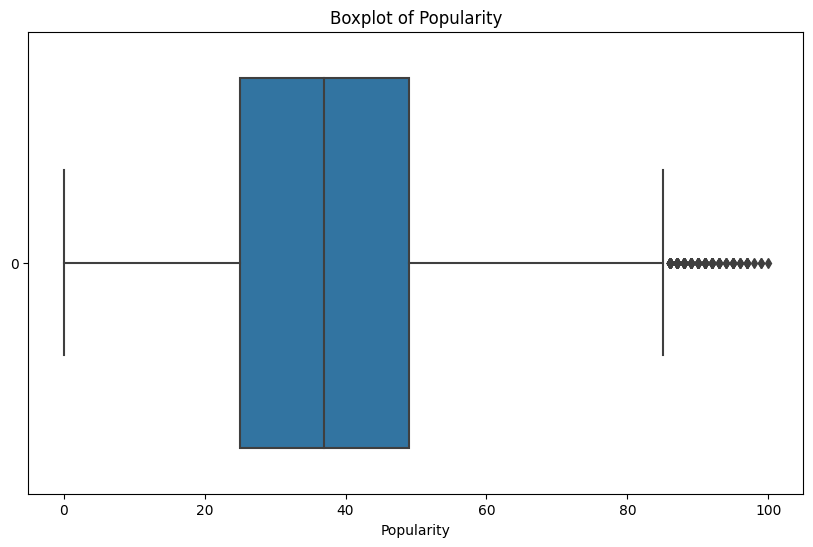

In [ ]:
plt.figure(figsize=(10, 6))
x = df['popularity']
sns.boxplot(x, orient='h')
plt.xlabel('Popularity')
plt.title('Boxplot of Popularity')
plt.show()

What can we see from this:
*   The 50% percentile is roughly 37
*   Q3 is approximately 49/50
*   Q1 is approximately 25
*   IQR = Q3-Q1 = 25/26
*   Min. = 0 and Max. = 100
*   Outliers lie beyond the whiskers:(Q1-1.5IQR) & (Q3+1.5IQR)
*   Therefore outlier bound for popularity is (-14, 88) # since our popularity can't be < 0, we can ignore the lower bound for the most part







Now we can find what songs are outliers based on this data... and we can do it using code :)

In [ ]:
popularity_outliers = df[df['popularity'] > 88]

# Display the respective popularity scores
print(popularity_outliers['popularity'])

outlier_sum = len(popularity_outliers)
print('Number of songs that are outliers:', outlier_sum)

9026       99
9027      100
9028       97
9029       92
9030       91
         ... 
138919     90
138922     92
166061     89
166063     89
166066     90
Name: popularity, Length: 83, dtype: int64
Number of songs that are outliers: 83


# **Training the Regressor:**

Why this model?

* Since we are interested in a numerical value, we know we should use a regressor
* KNN regressors require scaling that sometimes becomes difficult
* DecisionTrees are more prone to overfitting
* RandomForests just work better...


In [ ]:
from sklearn.model_selection import train_test_split

X = df[['danceability', 'acousticness', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness','tempo', 'valence']] # feature of the data
y = df['popularity'] # target variable

X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.2,random_state=0)

# Further splitting the temporary set into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=0)

# Creating and training the model
model = RandomForestRegressor(random_state = 0)
model.fit(X_train, y_train)

# Evaluating the model on the validation set
validation_score = model.score(X_val, y_val)
print('The model score on the validation set (R^2) is:', validation_score)

# Evaluating the model on the test set
test_score = model.score(X_test, y_test)
print('The model score on the test set (R^2) is:', test_score)

# Now you can use the trained model for predictions on new data
new_row_values = {
    'danceability': .159,
    'acousticness': .5,
    'duration_ms': 99373,
    'energy': .79,
    'instrumentalness': .005,
    'liveness': .027,
    'loudness': -8,
    'speechiness': .005,
    'tempo': 177,
    'valence': .81
}

new_row_df = pd.DataFrame([new_row_values])

# Use the trained model to make predictions
prediction = model.predict(new_row_df)
print('The model predicts:', prediction)


from sklearn.metrics import mean_squared_error, mean_absolute_error

validation_predictions = model.predict(X_val)

# Calculating Mean Squared Error on the validation set
mse_validation = mean_squared_error(y_val, validation_predictions)
print('Mean Squared Error on the validation set:', mse_validation)

# Calculating Mean Absolute Error on the validation set
mae_validation = mean_absolute_error(y_val, validation_predictions)
print('Mean Absolute Error on the validation set:', mae_validation)


The model score on the validation set (R^2) is: 0.33519993043459495
The model score on the test set (R^2) is: 0.3357850647185705
The model predicts: [22.65]
Mean Squared Error on the validation set: 199.3547637370455
Mean Absolute Error on the validation set: 10.959760997495568


Our MSE is a little too high. Interpretation will tell us that, on average, our popularity score prediction will be around +/- 14(with change). This is not so good, and some more hyperparameter tuning is required to get an optimal model.

We tried fiddling with the parameters of the regressor (max_depth, min_samples_split, etc.); however, it only raise our MSE so we took it out

# **Visualizaton #2**

Scatter and Residual Plot:

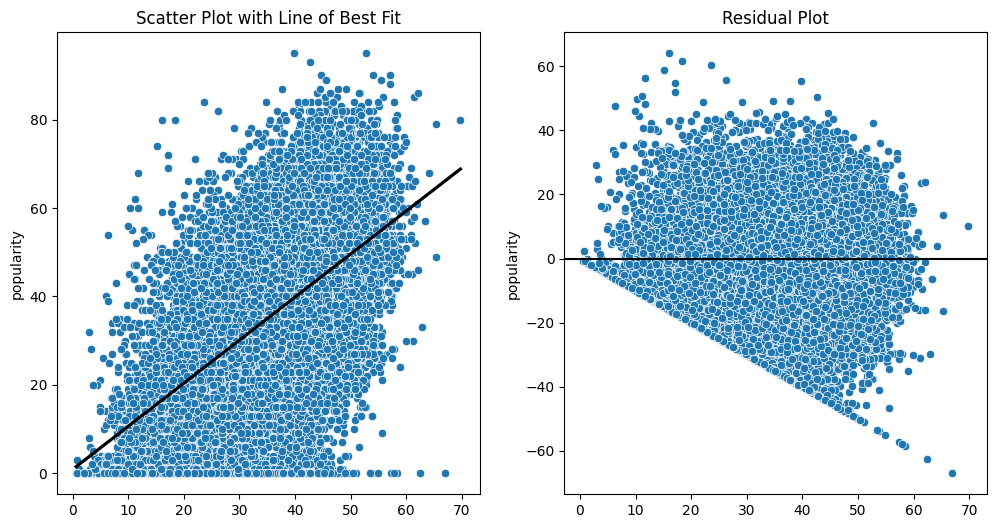

In [ ]:
plt.figure(figsize=(12, 6))

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(x= validation_predictions, y=y_val)
plt.title('Scatter Plot with Line of Best Fit')

# Line of best fit
sns.regplot(x=validation_predictions, y=y_val, scatter=False, color='black')

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_val - validation_predictions
sns.scatterplot(x=validation_predictions, y=residuals)
plt.axhline(y=0, color='black')
plt.title('Residual Plot')

plt.show()

# **Training the Classifier:**

The idea behind this classifier is to categorize the predicted populrity into two groups — 0 and 1 — based on a popularity threshold (37). We chose this threshold because it represents the median popularity score in our dataset — and as we know, median scores are outlier-resistant. If the predicted popularity of a song is <37, it is classified as 0; conversely, if predicted popularity of a song is ≥37, it is classified as 1.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# converts the values into binaries
y_train_binary = (y_train >= 37).astype(int)
y_val_binary = (y_val >= 37).astype(int)
y_test_binary = (y_test >= 37).astype(int)

# Creating and training the classifier
classifier = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 4, min_samples_split = 2, random_state=0)
classifier.fit(X_train, y_train_binary)

# Evaluating the classifier on the validation set
validation_predictions_binary = classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val_binary, validation_predictions_binary)

print('The classifier accuracy on the validation set is:', validation_accuracy)
print('Classification Report on Validation Set:\n', classification_report(y_val_binary, validation_predictions_binary))
print('Confusion Matrix on Validation Set:\n', confusion_matrix(y_val_binary, validation_predictions_binary))

# Evaluating the classifier on the test set
test_predictions_binary = classifier.predict(X_test)
test_accuracy = accuracy_score(y_test_binary, test_predictions_binary)

print('The classifier accuracy on the test set is:', test_accuracy)
print('Classification Report on Test Set:\n', classification_report(y_test_binary, test_predictions_binary))
print('Confusion Matrix on Test Set:\n', confusion_matrix(y_test_binary, test_predictions_binary))

# Now you can use the trained classifier for predictions on new data
new_row_binary = (prediction >= 37).astype(int)
print('The classifier predicts:', new_row_binary)


The classifier accuracy on the validation set is: 0.6953827632603923
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.74      0.59      0.65     13818
           1       0.67      0.80      0.73     14424

    accuracy                           0.70     28242
   macro avg       0.70      0.69      0.69     28242
weighted avg       0.70      0.70      0.69     28242

Confusion Matrix on Validation Set:
 [[ 8115  5703]
 [ 2900 11524]]
The classifier accuracy on the test set is: 0.6853136949440589
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.72      0.58      0.64      3455
           1       0.66      0.78      0.72      3606

    accuracy                           0.69      7061
   macro avg       0.69      0.68      0.68      7061
weighted avg       0.69      0.69      0.68      7061

Confusion Matrix on Test Set:
 [[2018 1437]
 [ 785 2821]]
The classi

In [ ]:
new_row_values = {
    'danceability': 0.159,
    'acousticness': 0.5,
    'duration_ms': 99373,
    'energy': 0.79,
    'instrumentalness': 0.005,
    'liveness': 0.027,
    'loudness': -8,
    'speechiness': 0.005,
    'tempo': 177,
    'valence': 0.81
}

new_row_df = pd.DataFrame([new_row_values])

# Use the trained classifier to make predictions
prediction = classifier.predict(new_row_df)

# Convert the predicted value to 0 or 1 based on the threshold (37)...
# The classifier already sorts into binary classifications, but this is nice to have
predicted_label = 1 if prediction >= 37 else 0

print('The model predicts:', predicted_label)

The model predicts: 0


The classifier on the other hand does pretty well on our test set, with an accuracy score of roughly 69.2%

* Adding max_dept = 10, min_samples_leaf = 4, min_samples_split = 2 increased the accuracy of our model by nearly 5 percent (the original accuracy was 64.5%)
* The confusion matrix tells us how many true positive, true negative, false positive, and false negative values our model completed
  * As you can see, it's not the best but it is something
  * More hyperparameter tuning is necessary for an optimal result

# **Visualization #3:**

This visualization utilizes the matplotlib and seaborn libraies. Specifically, this subplot displays a histogram for each column in the dataframe. Finally, these histograms utilize a Kernel Density Estimation (KDE) which estimates the probability density function (PDF) of the variable.  

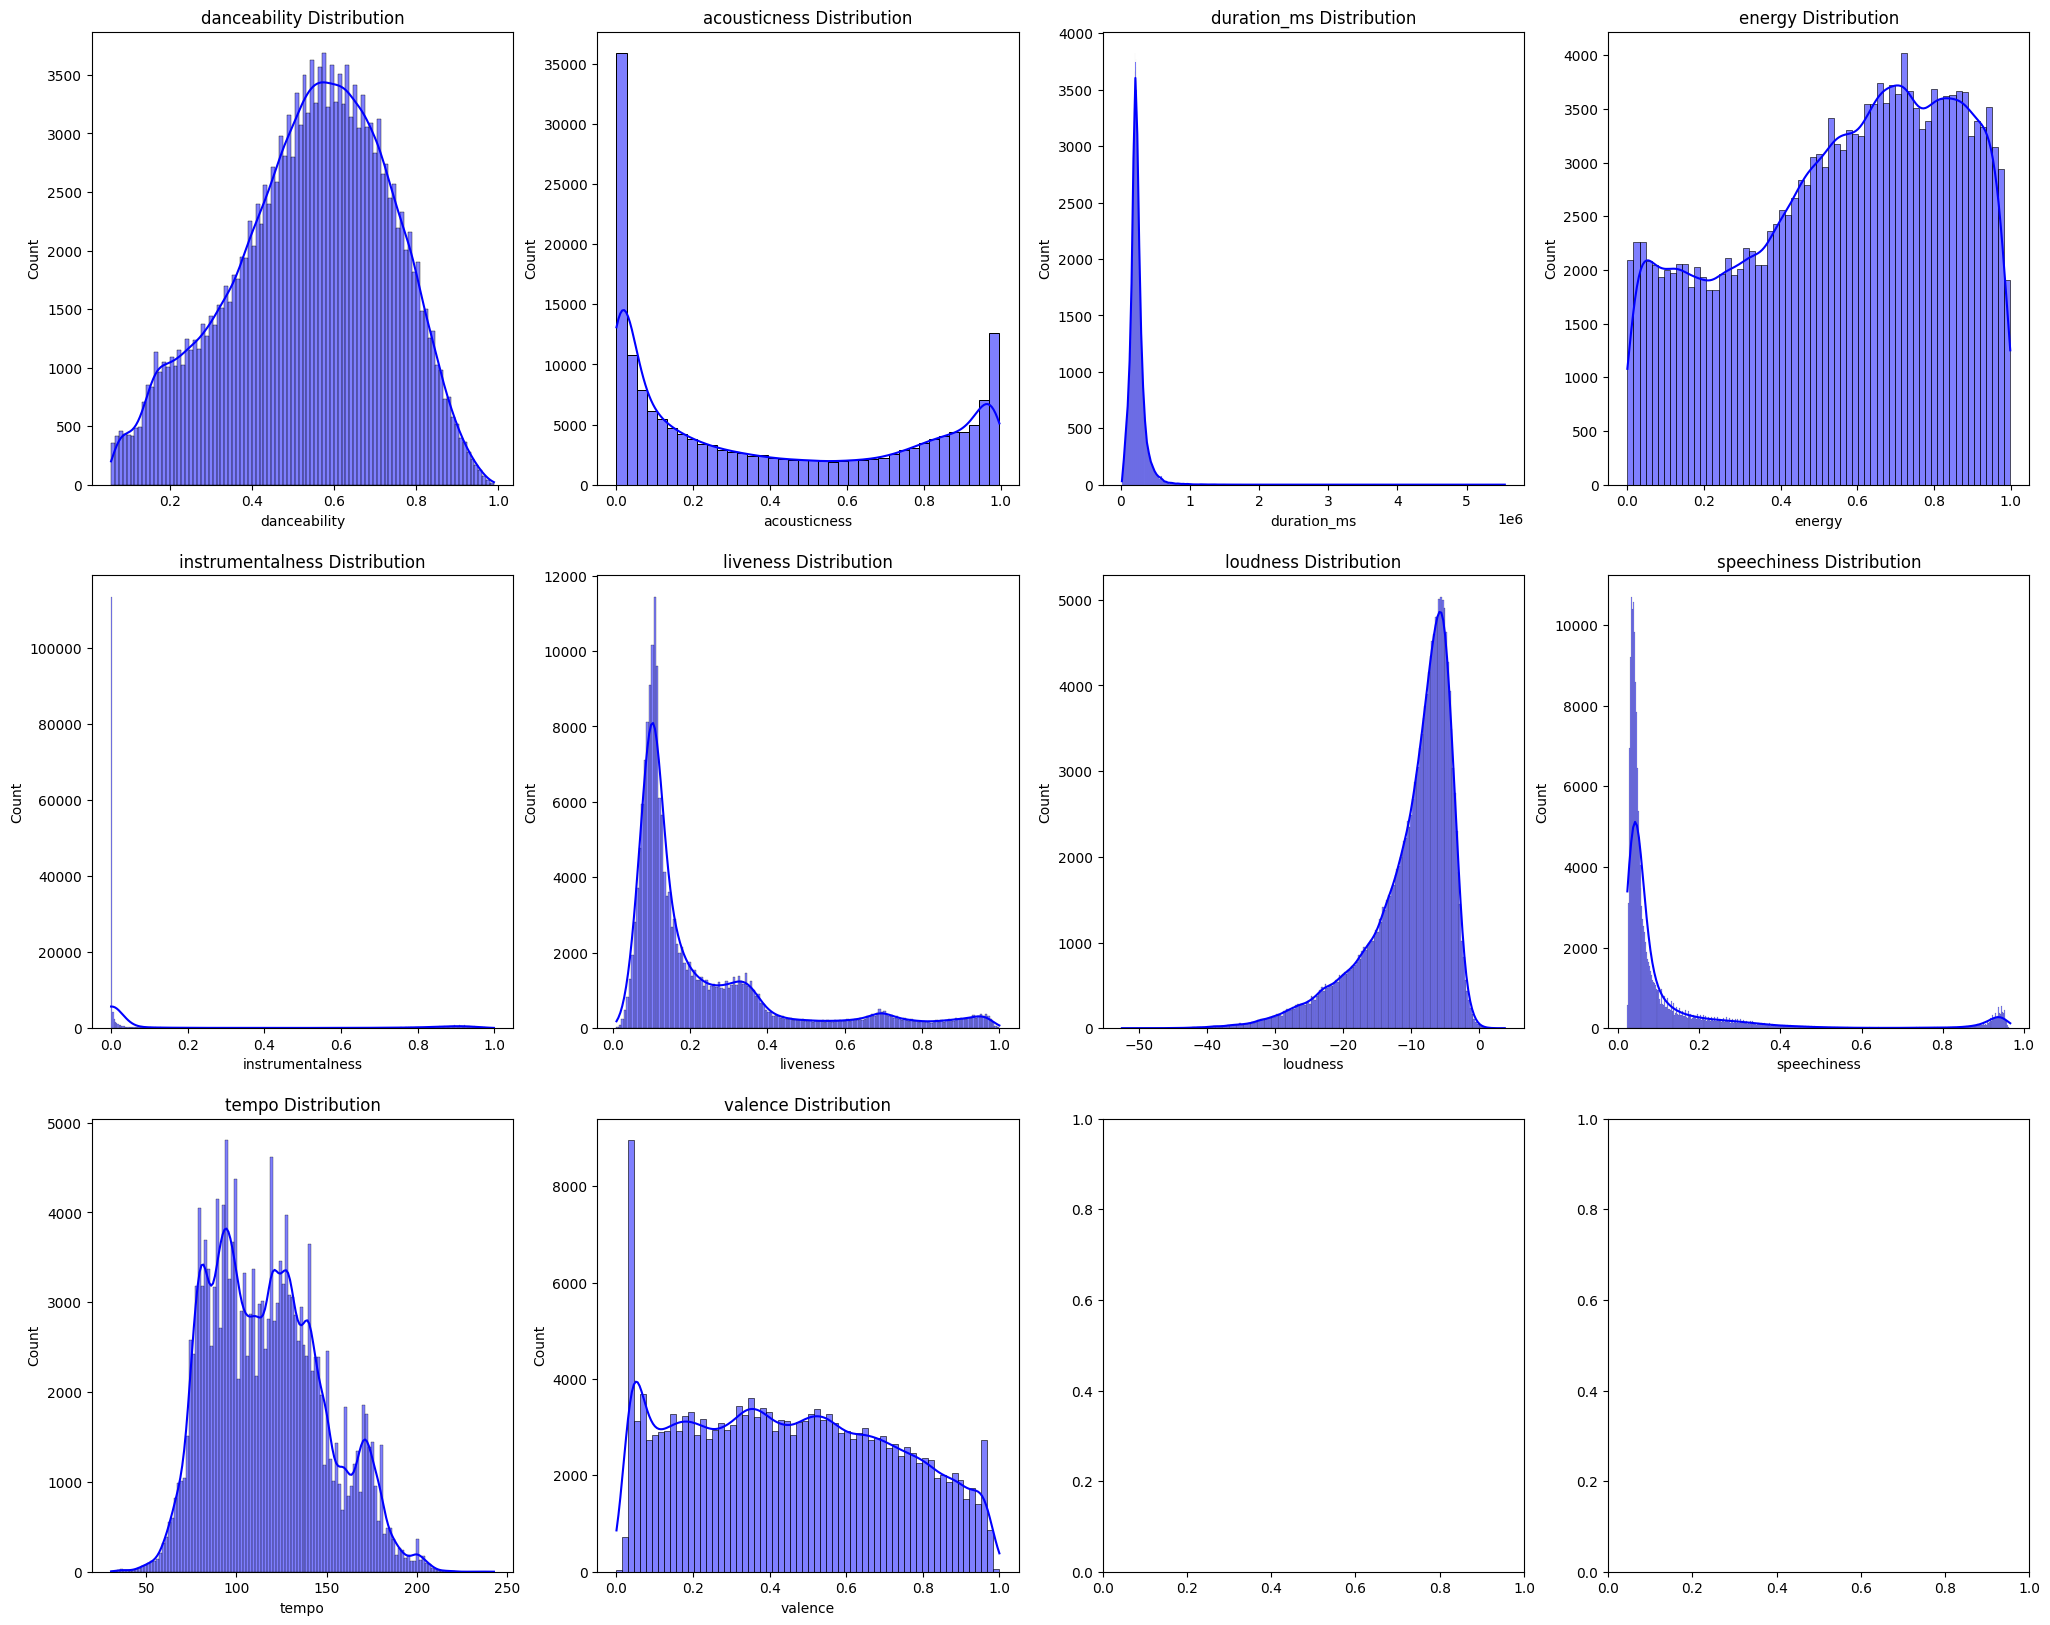

In [ ]:
f, ax = plt.subplots(3, 4, figsize=(25, 20))

for i, col in enumerate(X.columns):
    sns.histplot(data=df, x=col, kde=True, color='blue', ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(f'{col} Distribution')

plt.show()

# **Visualization #4:**

This next visualization is a correlation matrix/ heatmap that utilizes Seaborn's 'heatmap' function. This plot calculates the 'pearson' correlation coefficient and stores the number (between -1 and 1) in the cor_numVar variable.

<ipython-input-14-a5ca32312483>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_numVar = df.corr(method='pearson')


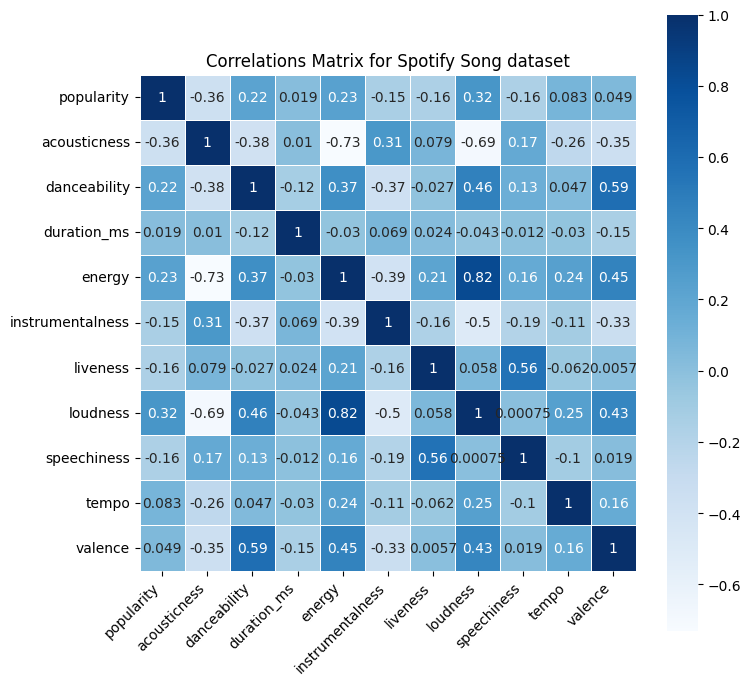

In [ ]:
cor_numVar = df.corr(method='pearson')


# Plotting the correlation matrix
plt.figure(figsize=(8, 8))
corrplot = sns.heatmap(cor_numVar, annot=True, cmap='Blues', square=True, linewidths=0.5, linecolor='white')
corrplot.set_xticklabels(corrplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlations Matrix for Spotify Song dataset')
plt.show()

# **Visualization #5:**

This next visualization is a bar chart/ Seaborn countplot (which is used for categorical data) to answer the question of which genre was the most apparent in our dataset

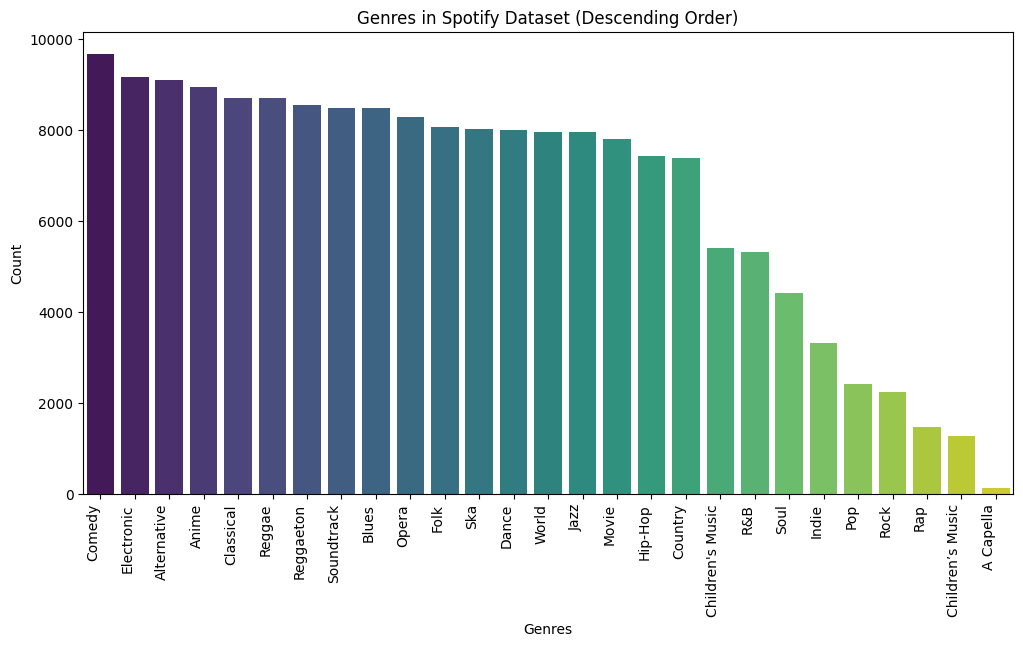

In [ ]:
genre_order = df['genre'].value_counts().index
plt.figure(figsize=(12, 6))

# Plots the categorical count plot in descending order
sns.countplot(data=df, x='genre', order=genre_order, palette='viridis') # seaborn categorical count plot
plt.xticks(rotation=90, ha='right')
plt.xlabel("Genres")
plt.ylabel("Count")
plt.title("Genres in Spotify Dataset (Descending Order)")
plt.show()

# **Visualization #6:**

This last visualization looks like a lot, but is actually fairly simple. This uses Seaborn's 'pairplot' function to create a matrix of scatterplots for the features in the data. if you look closely, it is basically a visual representation of what is happening in our correlation matrix (Visulaization #2)

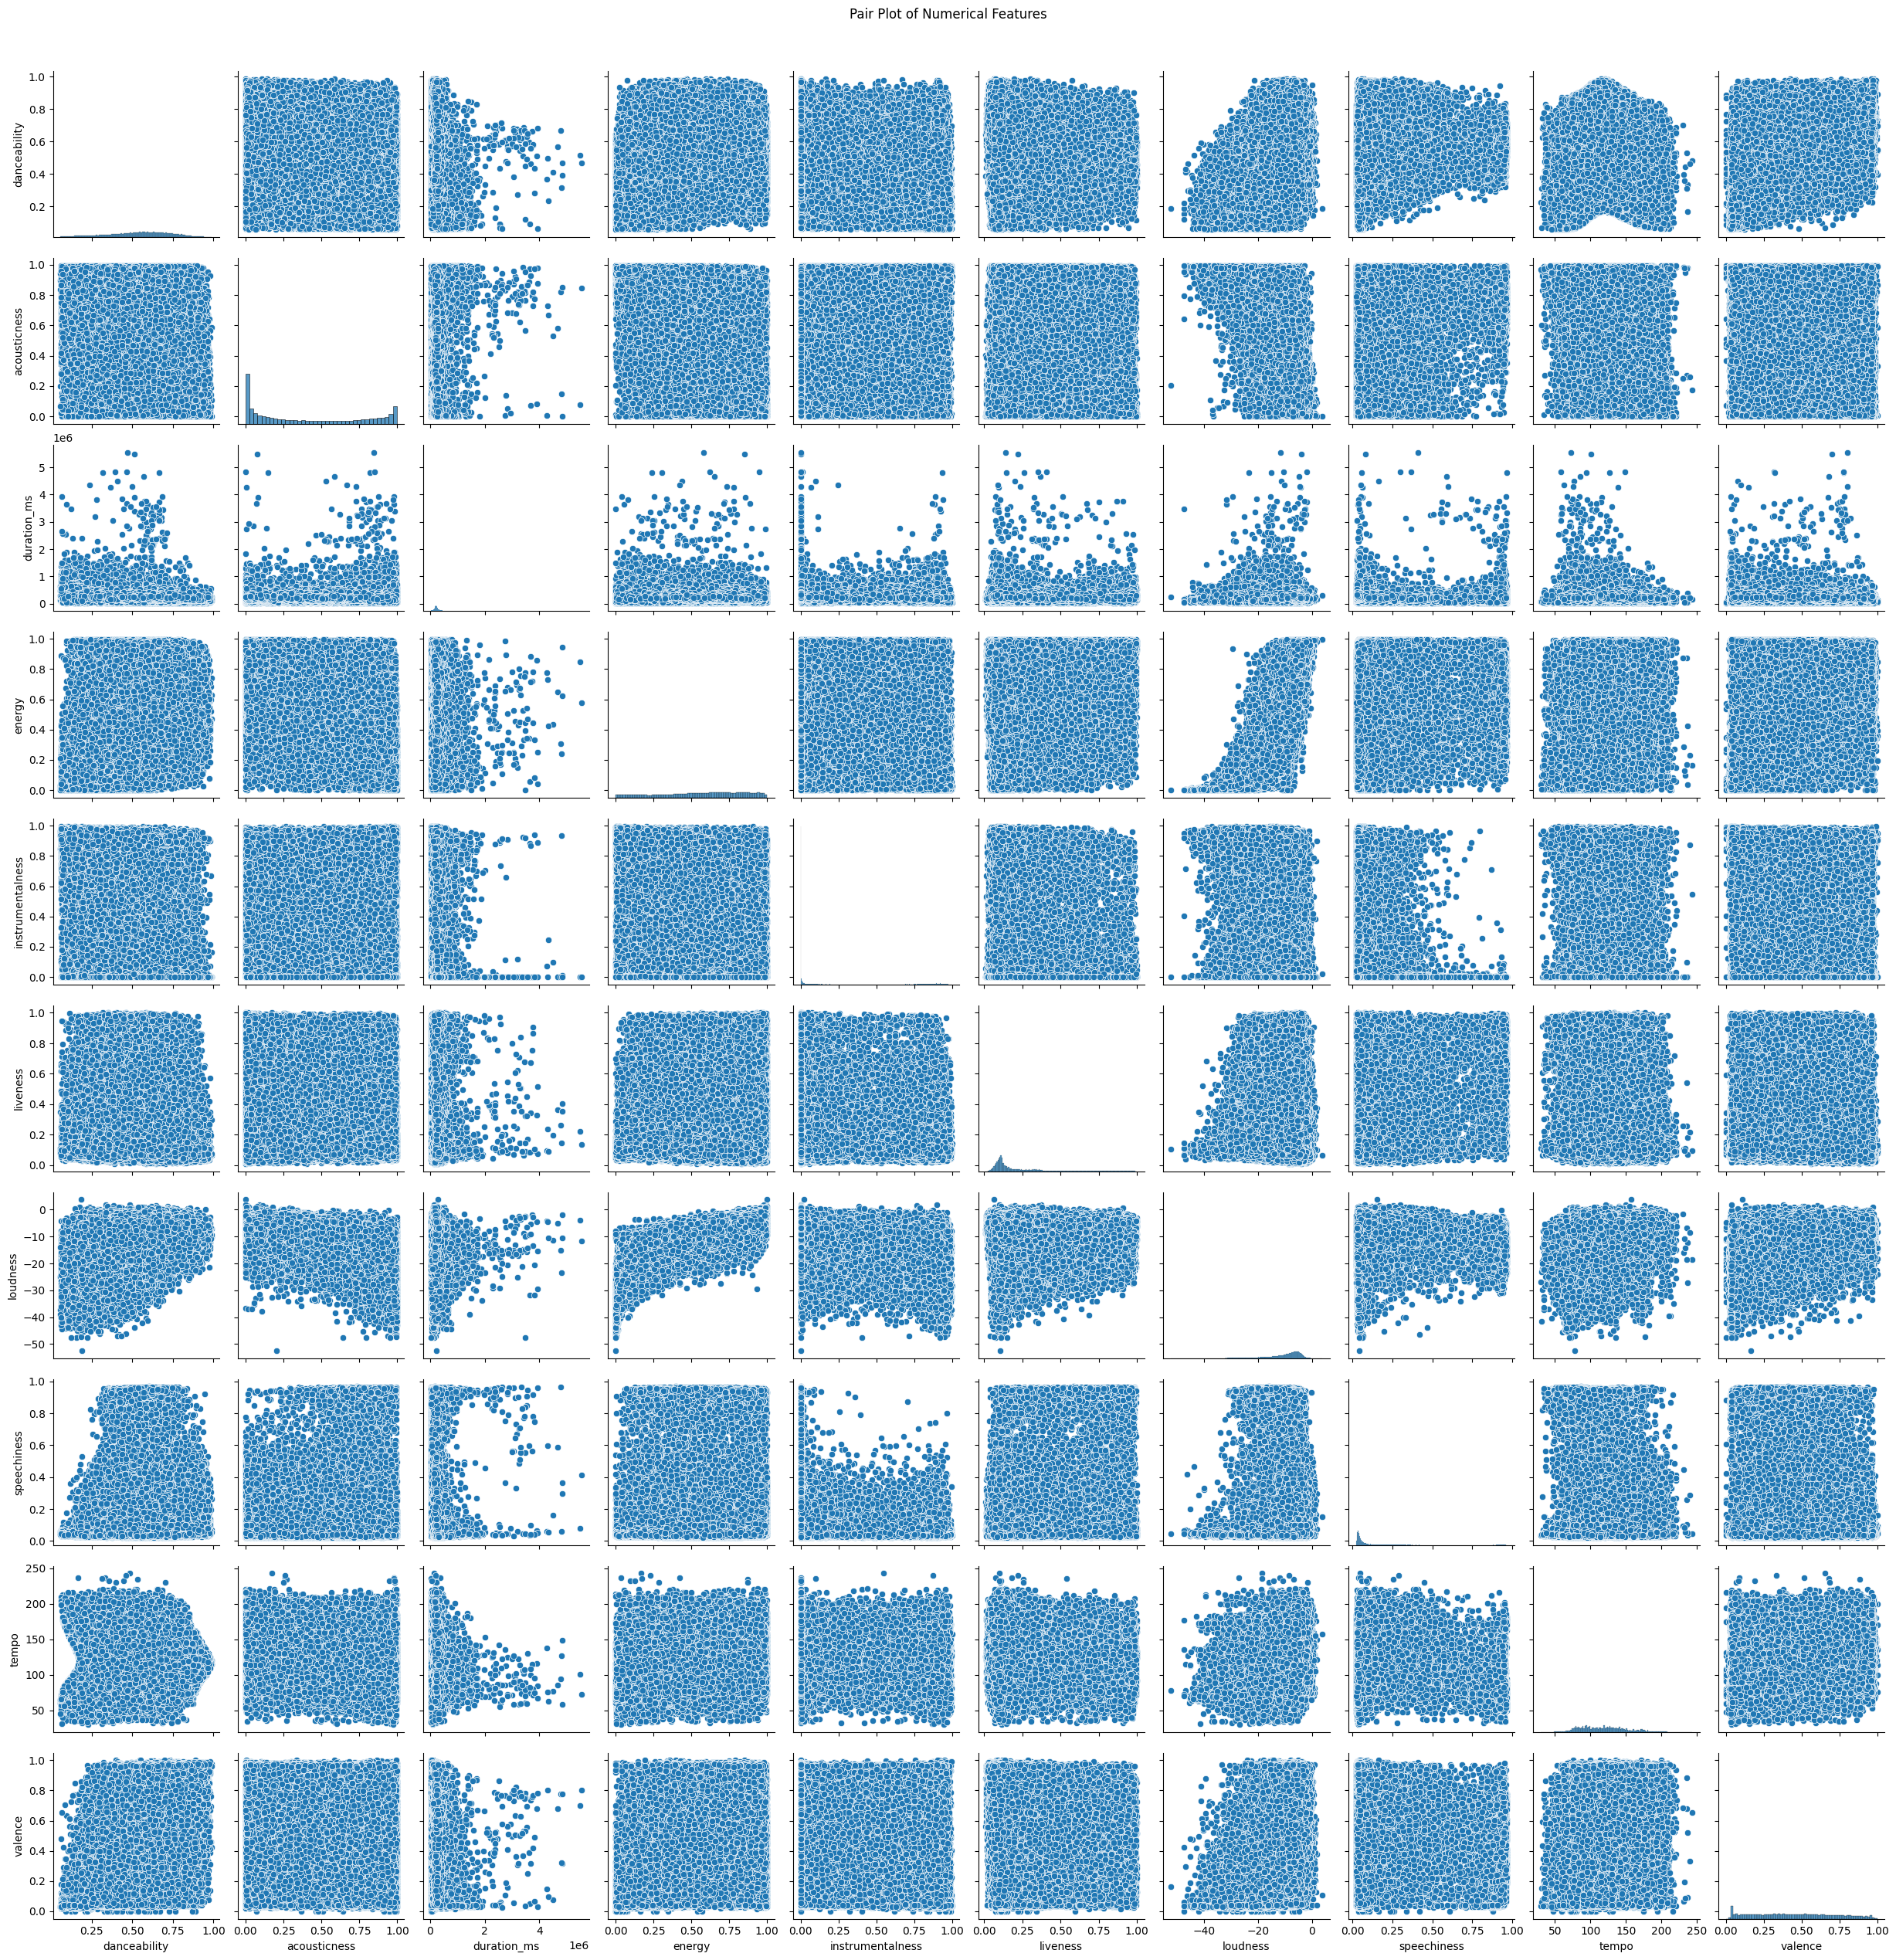

In [ ]:
sns.pairplot(df[['danceability', 'acousticness', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness','tempo', 'valence']])
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()